## Analyze A/B Test Results




## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#Conclusion)
- [Resources](#Resources)

<a id='intro'></a>
### Introduction
 
In this project, we will be working to understand the results of an A/B test run by an e-commerce website.  our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

Importing required libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline
random.seed(42)

Importing the CSV file and assess the columns first

In [2]:
df = pd.read_csv("ab_data.csv")

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Finding the numbre of rows

In [3]:
df.shape[0]

294478

The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't match.

In [6]:
#summing the posibilties 

df.query('group == "treatment" and landing_page != "new_page"').shape[0] + df.query('group != "treatment" and landing_page == "new_page"').shape[0]

3893

checking if there is missing values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


As we can see from the above code there is no missing values 

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

In [8]:
#in this scenario we will keep just treatment with new_page and  control with old_page

df_new = df.query('group == "treatment" and landing_page == "new_page"')
df_old = df.query("group == 'control' and landing_page == 'old_page'")
df2 = df_new.append(df_old)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

The number of unique **user_id**s in **df2**

In [10]:
df2['user_id'].nunique()

290584

Finding if there is duplicated user id 

In [11]:
df2[df2['user_id'].duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Removing the duplicated user id 

In [13]:
df2 = df2.drop(2893)


The probability of an individual converting regardless of the page they receive

In [14]:
df2['converted'].mean()

0.11959708724499628

The probability of the converted individual by the group column

In [15]:
df2.groupby('group')['converted'].mean()

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

The probability that an individual received the new page

In [16]:
df2.query("landing_page == 'new_page'")['user_id'].count() / df2.shape[0]

0.5000619442226688

explaining whether there is sufficient evidence to conclude that the new treatment page leads to more conversions.


>As we can see that converted probability equal to around 0.12 and the probability of the individual recives a page equals to 0.5 which by logic tells us that the new page will yield 0.06 converted individual considering these numbers tells us that the new page >will not accomplish the required goal


<a id='ab_test'></a>
### Part II - A/B Test

Here we will be using the hypothesis test to our assumptions and then test it out to fiqure the descion that needs to be taken 

In [17]:
df2.groupby('landing_page')['converted'].mean()

landing_page
new_page    0.118808
old_page    0.120386
Name: converted, dtype: float64



>Null hypothesis  P𝑜𝑙𝑑 = Pnew
>
>alternative hypothesis    𝑝𝑛𝑒𝑤 > P𝑜𝑙𝑑

Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br>
We will be Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

The **conversion rate** for $p_{new}$ under the null? 

In [18]:
#We assumed from the null that Pold will equal to be pnew so 
Pnew_null = df2['converted'].mean()
Pnew_null


0.11959708724499628

The **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
Pold_null = df2['converted'].mean()
Pold_null

0.11959708724499628

$n_{new}$, the number of individuals in the treatment group

In [20]:
Nnew = df.query('group == "treatment" and landing_page == "new_page"').shape[0]
Nnew

145311

$n_{old}$, the number of individuals in the control group

In [21]:
Nold = df.query('group == "control" and landing_page == "old_page"').shape[0]
Nold

145274

Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.

In [22]:
new_page_converted = df2.query('group == "treatment" and landing_page == "new_page"')

Pnew = new_page_converted['converted'].mean()

Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.

In [23]:
old_page_converted = df2.query('group == "control" and landing_page == "old_page"')

Pold = old_page_converted['converted'].mean()

$p_{new}$ - $p_{old}$ for the simulated values from the above codes.

In [24]:
Pnew - Pold

-0.0015782389853555567

Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in the above codes.

In [46]:
#here we used the binomial distributation to find the diffs between the new page and the old page
p_diffs = []
p_new_bi = np.random.binomial(Nnew , Pnew_null , 10000)/Nnew
p_old_bi = np.random.binomial(Nold , Pold_null, 10000)/Nold

p_diffs = p_new_bi - p_old_bi

p_diffs = np.array(p_diffs)

Ploting a histogram of the **p_diffs**.

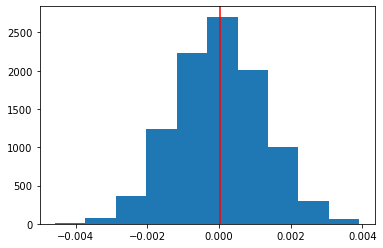

In [47]:
Null = np.random.normal(0 ,p_diffs.std() , 10000)
plt.hist(Null);
plt.axvline(p_diffs.mean() , c = "r");

Finding the P value

In [48]:
#here we are testing the alteranative hypothesis 
(p_diffs > (Pnew - Pold) ).mean()

0.9032


>
>From the above value which is the p value we found out that it is bigger than type one error so in that way we failed to 
>reject the null hypothesis
>

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [28]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]

n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

using `stats.proportions_ztest` to compute your test statistic and p-value.

In [29]:
# As per the document here the couts will be the number of success which we are taking about pold and pnew while
#the nobs is total number of rows we have also the last value is the null hypothesis
z , p =  proportions_ztest([convert_old , convert_new],[n_old , n_new], 0)
z , p

(1.3109241984234394, 0.18988337448195103)

The z score since it is postive it means that the standard deviation from the pold is bigger by 1.31 unites from p new also the p values seems nearly identical which yields that the two provides the same insight


<a id='regression'></a>
### Part III - A regression approach

Here we will be using the Multiple linear regression model to see if there is a significant difference in conversion based on which page a customer receives

In [30]:
df2.group.unique()

array(['treatment', 'control'], dtype=object)

In [31]:
#convert the categorical columns in order to work with it in the fitting the model 
df2['intercept'] = 1 
df2[['control' , 'treatment']] = pd.get_dummies(df2['group'])
df2[['new_page' , 'old_page']] = pd.get_dummies(df2['landing_page'])

In [32]:
df2 = df2.drop(['control' , 'old_page'] , axis = 1 )

In [33]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,treatment,new_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,1


In [34]:
#building and fitting the model 
log_mod = sm.Logit(df2['converted'] , df2[['intercept' , 'treatment']])
res = log_mod.fit();
res.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 09 Mar 2021   Pseudo R-squ.:               8.077e-06
Time:                        23:30:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value associated with **ab_page** in the below we are descriping why the result is different from part 2 


>0.19 it is different from the value we found in part 2 since here we are testing if there is relationship between the page type and the conversion rate 

Discussing why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?



>adding other factors for most of the cases will be great idea to get more insights and more axxuracy but what will make  it
>worse is when factors correlate to each other 

Now we wanted to check if country had an impact on conversion

In [35]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [36]:
df_countries = df_countries.join(pd.get_dummies(df_countries['country']))
df_countries.head()

,user_id,country,CA,UK,US
0,834778,UK,0,1,0
1,928468,US,0,0,1
2,822059,UK,0,1,0
3,711597,UK,0,1,0
4,710616,UK,0,1,0


In [37]:
df_countries.head()
df_countries.drop('country' , axis = 1 )

,user_id,CA,UK,US
0,834778,0,1,0
1,928468,0,0,1
2,822059,0,1,0
3,711597,0,1,0
4,710616,0,1,0
...,...,...,...,...
290579,653118,0,0,1
290580,878226,0,1,0
290581,799368,0,1,0
290582,655535,1,0,0


In [38]:
#here I used the merge instead of join as i was facing an issue with overlaping a i found this answer on stackoverflow 
df2 = df2.merge(df_countries , on = 'user_id' , how = 'inner')

In [39]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,treatment,new_page,country,CA,UK,US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,US,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,US,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,1,CA,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,1,UK,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,1,CA,1,0,0


In [40]:
df2['intercept'] =  1

lm_countries = sm.Logit(df2['converted'] , df2[['CA' , 'US' , 'intercept']])
res_countries = lm_countries.fit()
res_countries.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 09 Mar 2021   Pseudo R-squ.:               1.521e-05
Time:                        23:31:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
==============================================================================
"""

As we can see from the p values for where user comes from we found out that countries is not a factor that we can depend on it 

Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. 


In [41]:
df2["CA_treatment"] = df2['CA'] * df2['treatment']
df2['US_treatment'] = df2['US'] * df2['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,treatment,new_page,country,CA,UK,US,CA_treatment,US_treatment
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,US,0,0,1,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,US,0,0,1,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,1,CA,1,0,0,1,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,1,UK,0,1,0,0,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,1,CA,1,0,0,1,0


In [42]:
df2['intercept'] = 1

lm_final  = sm.Logit(df2['converted'] , df2[['intercept' ,'new_page' , 'CA' , 'US' , 'CA_treatment' , 'US_treatment']])
res_final  = lm_final.fit()
res_final.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 09 Mar 2021   Pseudo R-squ.:               3.482e-05
Time:                        23:31:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -1.9922      0.016   -123.457      0.000      -2.024      -1.961
new_page         0.0108      0.023      0.475      0.635      -0.034       0.056
CA              -0.0118      0.040     -0.296      0.767      -0.090       0.066
US               0.0057      0.019      0.306      0.760      -0.031       0.043
CA_treatment    -0.0783      0.057     -1.378      0.168      -0.190       0.033
US_treatment    -0.0314      0.027     -1.181      0.238      -0.084       0.021
================================================================================
"""

As we can see from the p values and depedning the 5% type 1 error using the country feature doesnt help us 

<a id='Conclusion'></a>
### Conclusion

1.we used different approaches to check about the null hypothesis in all of them wen conclued that we should keep the old page since there will be no huge significance 

2.our result might change if we conducted the analysis on bigger data collcted from this study


<a id='Resources'></a>
### Resources

1.Stack overflow website